In [1]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [2]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)
from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import data_files
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
kwargs = cfg['api']

In [4]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import imp
from models import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
]

In [5]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(354192, 50) (354192,) (39421, 50) (39421,)


In [23]:
import imp
imp.reload(models)
model_list = [
     ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
#     ('aec',models.aec.AecModel,dict(istrain=False)),
     #('xg',models.xg.XgModel,dict(istrain=False)),
     #('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
     #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
#    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
#     ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
     #('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
     #('idg',models.icadisengan.IcaDisentangleGanModel,dict(istrain=False)),
     #('mdg',models.moddisengan.DisentangleModel,dict(istrain=True)),
    ('tsnesimple',models.tsne_simple.TsneSimple,dict(istrain=False)),
#    ('simple',models.simple.Simple,dict(istrain=False)),
#    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
]

In [24]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [25]:
val_inds.shape

(46362,)

In [26]:

def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = [{},{}]
raw = {}
for n,p in enumerate(['trainpath','testpath']):
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    val_eras = sorted([x for x in np.unique(eras__) if x not in ['eraX']])
    raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__.values)
        raw[p]['m'][name]={'y_pred':y_pred}
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
        ll[name] = pd.DataFrame(ll[name])
    ll_list[n].update(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


trainpath aecgan cons:0.6833 logloss:0.6925
trainpath tsnesimple cons:0.7667 logloss:0.6921
testpath aecgan cons:0.8333 logloss:0.6924
testpath tsnesimple cons:1.0000 logloss:0.6916


In [27]:


print('ok')
name = 'opt'
for n,p in enumerate(['trainpath','testpath']):
    y_true = raw[p]['y_true']
    pred_list = []
    for k,v in raw[p]['m'].items():
        pred_list.append(v['y_pred'].squeeze())
    
    if p =='trainpath':
        w = opt.opt_weights(pred_list,y_true)
    
    pred_list = np.array(pred_list)
    # calculate pred
    y_pred = np.dot(w,pred_list)
    print(y_pred.shape)
    #raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    val_eras = raw[p]['val_eras']
    eras__ = raw[p]['eras']
    y__ = raw[p]['y_true']
    print(y__.shape)
    ll={name:[]}
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
    ll[name] = pd.DataFrame(ll[name])
    
    ll_list[n].update(ll)


ok
!
Ensemble Score: 0.24943923702271742
Best Weights: [ 0.63444959  0.36555041]
!
Ensemble Score: 0.24960430799285513
Best Weights: [ 0.10806419  0.89193581]
!
Ensemble Score: 0.24946529310587126
Best Weights: [ 0.91910252  0.08089748]
!
Ensemble Score: 0.2495223076130663
Best Weights: [ 0.27421182  0.72578818]
!
Ensemble Score: 0.2494472676541392
Best Weights: [ 0.54859621  0.45140379]
!
Ensemble Score: 0.24946582310960927
Best Weights: [ 0.92135926  0.07864074]
!
Ensemble Score: 0.24943860772606952
Best Weights: [ 0.64894532  0.35105468]
!
Ensemble Score: 0.2494380346297009
Best Weights: [ 0.67236074  0.32763926]
!
Ensemble Score: 0.24944512518639908
Best Weights: [ 0.56532537  0.43467463]
!
Ensemble Score: 0.2495195858263596
Best Weights: [ 0.28089587  0.71910413]
-----------------------------------
candidate weight info {'weights': array([ 0.67236074,  0.32763926]), 'score': 0.2494380346297009}
-----------------------------------
(393613,)
(393613,)
(243411,)
(243411,)


In [28]:
print('\n'.join(['{} {:1.4f}'.format(m[0],w0) for m,w0 in zip(model_list,w)]))

aecgan 0.6724
tsnesimple 0.3276


aecgan
0.49967 0.6833 82 120
0.49964 0.8333 10 12
--
opt
0.49943 0.8000 96 120
0.49926 1.0000 12 12
--
tsnesimple
0.49948 0.7667 92 120
0.49924 1.0000 12 12
--


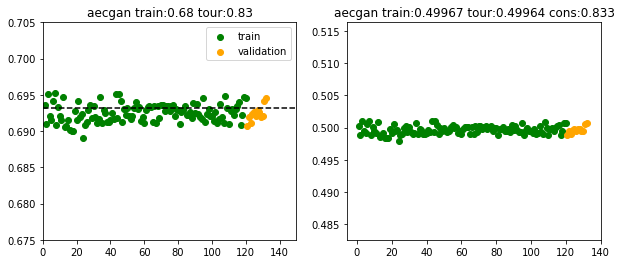

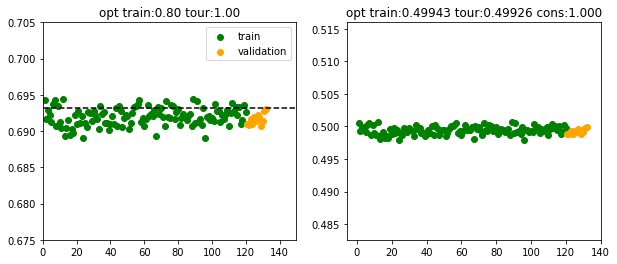

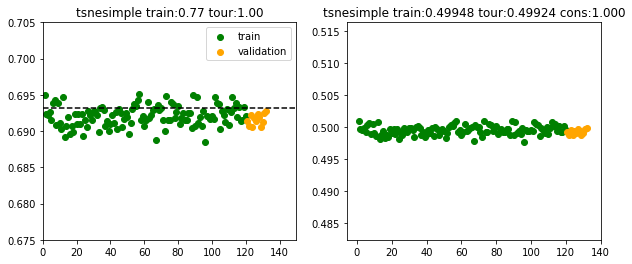

In [29]:
m_list = ['disentangle']#,'aecgan'
m_list = list(sorted(ll_list[0].keys()))

for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.675,0.705)
    plt.xlim(0,150)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [ ]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

In [ ]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))